### Experiments

#### decoder_state_dict_adamw_25e_bs64_ffdim_4096_heads_32_mseloss_0.07`
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=32,
    ff_dim=4096,
    output_channels=3
)
```

#### 'decoder_state_dict_adamw_50e_numblocks_2_ffdim_2048_heads_16_mseloss_0.06.pth'
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=2048,
    output_channels=3
)
```

#### decoder_state_dict_adamw_40e_numblocks_2_ffdim_4096_heads_16_mseloss_0.05.pth

```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
```

#### 'decoder_t8_preds_detr101dc5_adamw_30e_numblocks_2_ffdim_4096_heads_16.pth' -> loss 0.043 | train reconstruct loss: 0.041| test reconstruct loss: 0.21
This arch takes 6h to train on 150k objects. For Shanghaitech, this would mean 10x, so infeasible or not worth it. We have to reduce the overhead.
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
```

#### 'decoder_t8_preds_detr101dc5_adamw_numblocks_1_ffdim_4096_heads_16.pth'
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
- Avenue: 20 epochs - 3h | Loss: 0.054 | Train Reconstruct Loss: 0.0521 | Test reconstruct loss: 0.21
- Shanghaitech (v2): 7 epochs -  9h | Loss: 0.26 | Train Reconstruct Loss: 0.21 | Test reconstruct loss: 0.?
- UBNormal
```

#### 'decoder_v2_t8_preds_detr101dc5_adamw_numblocks_1_ffdim_4096_heads_32.pth'
```
decoder = UpsampleTransformerDecoderV2(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=32,
    ff_dim=4096,
    output_channels=3
)
- Avenue: 50 epochs - 8h | Loss: 0.0371| Train Reconstruct Loss: 0.0365 | Test reconstruct loss: 0.211
```

#### 'decoder_v2_t8_preds_detr101dc5_adamw_numblocks_1_ffdim_4096_heads_16.pth'
```
decoder = UpsampleTransformerDecoderV2(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
- Avenue: 50 epochs - 7h | Loss: 0.0343| Train Reconstruct Loss: 0.033 | Test reconstruct loss: 0.23
```

### Imports

In [16]:
import sys
sys.path.append('./ml-fastvit')

In [17]:
import timm
import torch
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as T
import torch.nn as nn
import models
import math
import matplotlib.pyplot as plt
import numpy as np
import gc

from torch import Tensor
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.models import create_model
from models.modules.mobileone import reparameterize_model
from PIL import Image
from urllib.request import urlopen

from UpsampleTransformerDecoder import UpsampleTransformerDecoder
from UpsampleTransformerDecoderV2 import UpsampleTransformerDecoderV2


# Before starting the training, make sure to clear any residual memory
gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [18]:
def imshow(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    # img = std * img + mean  # unnormalize
    # img = np.clip(img, 0, 1)  # clip any values outside the range [0, 1]
    plt.imshow(img)
    plt.show()

In [19]:
def plot_images_vs_reconstructed_images(images, reconstructed_imgs):
    # Move images back to cpu for visualization
    images = images.cpu()
    reconstructed_imgs = reconstructed_imgs.cpu()
    
    # Display original and reconstructed images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Images')
    imshow(vutils.make_grid(images, padding=2, normalize=True))
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Images')
    imshow(vutils.make_grid(reconstructed_imgs, padding=2, normalize=True))

In [20]:
transform = T.Compose([
        T.Resize((64, 64)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


### Initialize Encoder (Apple FastViT, T8)

In [6]:
# To Train from scratch/fine-tuning
encoder = create_model("fastvit_t8", fork_feat=True) # can turn fork_feat to False

checkpoint = torch.load('./pretrained/fastvit_t8.pth.tar')
encoder.load_state_dict(checkpoint['state_dict'], strict=False)

# For inference
# model.eval()      
encoder = reparameterize_model(encoder)
encoder = encoder.to(device)
encoder.eval()

FastViT(
  (patch_embed): Sequential(
    (0): MobileOneBlock(
      (se): Identity()
      (activation): GELU(approximate='none')
      (reparam_conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): MobileOneBlock(
      (se): Identity()
      (activation): GELU(approximate='none')
      (reparam_conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=48)
    )
    (2): MobileOneBlock(
      (se): Identity()
      (activation): GELU(approximate='none')
      (reparam_conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (network): ModuleList(
    (0): Sequential(
      (0): RepMixerBlock(
        (token_mixer): RepMixer(
          (reparam_conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48)
        )
        (convffn): ConvFFN(
          (conv): Sequential(
            (conv): Conv2d(48, 48, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=48, bias=False)
            (bn): 

### Initialize & Load Decoder

In [21]:
# Initialize the decoder
# decoder = UpsampleTransformerDecoder(
#     input_channels=384,
#     num_upsamples=5,  # Adjusted to 5 upsampling steps
#     num_blocks=1,
#     num_heads=16,
#     ff_dim=4096,
#     output_channels=3
# )

decoder = UpsampleTransformerDecoderV2(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)


# decoder = decoder.to(device)

In [22]:
decoder_model_path = 'decoder_v2_t8_preds_yolov8_adamw_numblocks_1_ffdim_4096_heads_16.pth'

# # Load the state dictionary
decoder.load_state_dict(torch.load(decoder_model_path))

# # This should be turned on only for test time. If we want to retrain, comment this line
# # If you are using a GPU for the model, don't forget to move the decoder to the GPU
decoder.to(device)

UpsampleTransformerDecoderV2(
  (up_blocks): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(384, 192, kernel_size=(2, 2), stride=(2, 2))
      (1): ResNetBlock(
        (conv1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): GELU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(192, 96, kernel_size=(2, 2), stride=(2, 2))
      (1): ResNetBlock(
        (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track

# Avenue

### Declare Train Dataloader

In [10]:
train_dataset = datasets.ImageFolder(root='./datasets/Avenue Dataset/objects/train/', transform=transform)

# Create the DataLoader to load the dataset.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)

print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 167641
    Root location: ./datasets/Avenue Dataset/objects/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


### Training Loop 

In [11]:
# Freeze encoder weights
for param in encoder.parameters():
    param.requires_grad = False

# Set up loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.Adam(decoder.parameters(), lr=0.001)
optimizer = optim.AdamW(decoder.parameters(), lr=0.001)

In [12]:
%%time
# Training loop
num_epochs = 50  # Define the number of epochs
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, _ in train_loader:  # Note the unpacking here to ignore the labels
        inputs = inputs.to(device)  # Move inputs to the device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through encoder and then decoder
        with torch.no_grad():  # We don't need to track gradients for the encoder
            latent_representation = encoder(inputs)[-1]  # Get the last latent space representation

        # Decoder reconstruction from latent space
        reconstructed_imgs = decoder(latent_representation)

        # Calculate loss
        loss = criterion(reconstructed_imgs, inputs)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

        losses.append(loss.item())

    if epoch % 5 == 0 and epoch != 0:
        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            # 'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss
        }
        torch.save(checkpoint, f'decoder_v2_avenue_checkpoint_epoch_{epoch+1}.pth')
    
    # Print loss every epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}')
    running_loss = 0.0

print('Finished Training')

Epoch 1, Loss: 0.1382
Epoch 2, Loss: 0.0902
Epoch 3, Loss: 0.0778
Epoch 4, Loss: 0.0705
Epoch 5, Loss: 0.0646
Epoch 6, Loss: 0.0609
Epoch 7, Loss: 0.0576
Epoch 8, Loss: 0.0550
Epoch 9, Loss: 0.0529
Epoch 10, Loss: 0.0511
Epoch 11, Loss: 0.0495
Epoch 12, Loss: 0.0481
Epoch 13, Loss: 0.0470
Epoch 14, Loss: 0.0458
Epoch 15, Loss: 0.0449
Epoch 16, Loss: 0.0442
Epoch 17, Loss: 0.0433
Epoch 18, Loss: 0.0426
Epoch 19, Loss: 0.0420
Epoch 20, Loss: 0.0414
Epoch 21, Loss: 0.0409
Epoch 22, Loss: 0.0405
Epoch 23, Loss: 0.0400
Epoch 24, Loss: 0.0396
Epoch 25, Loss: 0.0392
Epoch 26, Loss: 0.0388
Epoch 27, Loss: 0.0386
Epoch 28, Loss: 0.0382
Epoch 29, Loss: 0.0379
Epoch 30, Loss: 0.0376
Epoch 31, Loss: 0.0374
Epoch 32, Loss: 0.0372
Epoch 33, Loss: 0.0369
Epoch 34, Loss: 0.0366
Epoch 35, Loss: 0.0364
Epoch 36, Loss: 0.0362
Epoch 37, Loss: 0.0360
Epoch 38, Loss: 0.0359
Epoch 39, Loss: 0.0357
Epoch 40, Loss: 0.0355
Epoch 41, Loss: 0.0354
Epoch 42, Loss: 0.0352
Epoch 43, Loss: 0.0351
Epoch 44, Loss: 0.03

### Visualize Reconstruction Loss on Train Batch

In [23]:
# Get a batch of images from your dataloader
dataiter = iter(train_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = encoder(images)[-1]  # Get the last latent space representation
    print(latent_representation.shape)
    reconstructed_imgs = decoder(latent_representation)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 229, in __getitem__
    sample = self.loader(path)
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 268, in default_loader
    return pil_loader(path)
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 246, in pil_loader
    with open(path, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: './datasets/Avenue Dataset/objects/train/10/0993_object_3.jpg'


### Loss on Train Set

In [24]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in train_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            # Forward pass through the encoder and then the decoder
            latent_representation = encoder(images)[-1]  # Assuming the last output is the latent representation
            reconstructed_imgs = decoder(latent_representation)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f'Average reconstruction loss on the train set: {average_loss}')


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 229, in __getitem__
    sample = self.loader(path)
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 268, in default_loader
    return pil_loader(path)
  File "/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 246, in pil_loader
    with open(path, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: './datasets/Avenue Dataset/objects/train/01/0811_object_1.jpg'


### Save model state dict

In [15]:
# # Save the decoder state dictionary
# torch.save(decoder.state_dict(), 'decoder_v2_t8_preds_yolov8_adamw_numblocks_1_ffdim_4096_heads_16.pth')

### Declare Test Data Loader

In [12]:
test_dataset = datasets.ImageFolder(root='./datasets/Avenue Dataset/objects/test/', transform=transform)

# Create the DataLoader to load the dataset.
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)

print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 156457
    Root location: ./datasets/Avenue Dataset/objects/test/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


### Visualize Reconstruction Loss on Test Batch

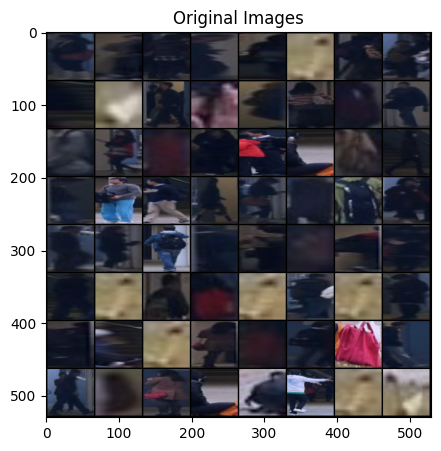

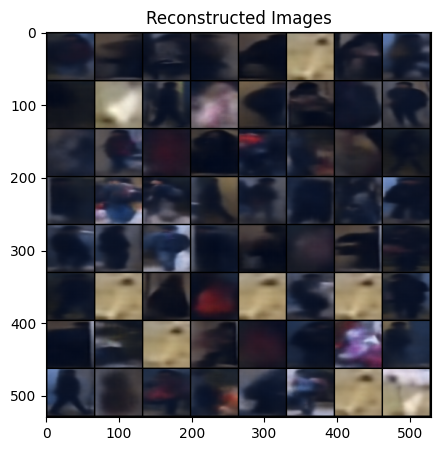

In [13]:
# Get a batch of images from your dataloader
dataiter = iter(test_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = encoder(images)[-1]  # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

### Loss on Test Set

In [14]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in test_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            # Forward pass through the encoder and then the decoder
            latent_representation = encoder(images)[-1]  # Assuming the last output is the latent representation
            reconstructed_imgs = decoder(latent_representation)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f'Average reconstruction loss on the test set: {average_loss}')

Average reconstruction loss on the test set: 0.23751636972395676


# ShanghaiTech

### Declare Train Dataloader

In [17]:
# Clear the CUDA cache
torch.cuda.empty_cache()

In [9]:
train_dataset = datasets.ImageFolder(root='./datasets/shanghaitech/objects/', transform=transform)

# Create the DataLoader to load the dataset.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)

print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 1458259
    Root location: ./datasets/shanghaitech/objects/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


### Training Loop

In [10]:
# Freeze encoder weights
for param in encoder.parameters():
    param.requires_grad = False

# Set up loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.Adam(decoder.parameters(), lr=0.001)
optimizer = optim.AdamW(decoder.parameters(), lr=0.001)

In [11]:
%%time
# Training loop
num_epochs = 7  # Define the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, _ in train_loader:  # Note the unpacking here to ignore the labels
        inputs = inputs.to(device)  # Move inputs to the device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through encoder and then decoder
        with torch.no_grad():  # We don't need to track gradients for the encoder
            latent_representation = encoder(inputs)[-1]  # Get the last latent space representation

        # Decoder reconstruction from latent space
        reconstructed_imgs = decoder(latent_representation)

        # Calculate loss
        loss = criterion(reconstructed_imgs, inputs)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    # Print loss every epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}')

    # Save checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        # 'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }
    torch.save(checkpoint, f'decoder_shanghaitech_checkpoint_epoch_{epoch+1}.pth')
    
    running_loss = 0.0

print('Finished Training')

Epoch 1, Loss: 0.3390
Epoch 2, Loss: 0.3001
Epoch 3, Loss: 0.2870
Epoch 4, Loss: 0.2795
Epoch 5, Loss: 0.2745
Epoch 6, Loss: 0.2710
Epoch 7, Loss: 0.2682
Finished Training
CPU times: user 7h 52min 24s, sys: 1h 1min 2s, total: 8h 53min 26s
Wall time: 8h 53min 32s


### Visualize Reconstruction Loss on Train Batch

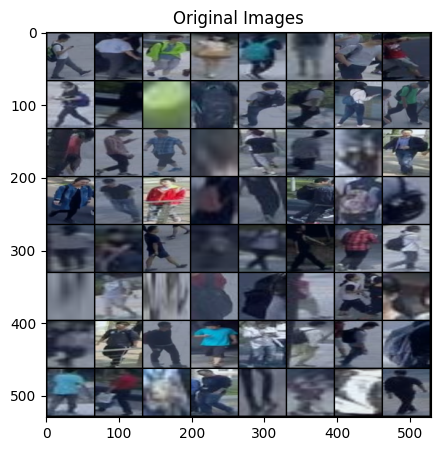

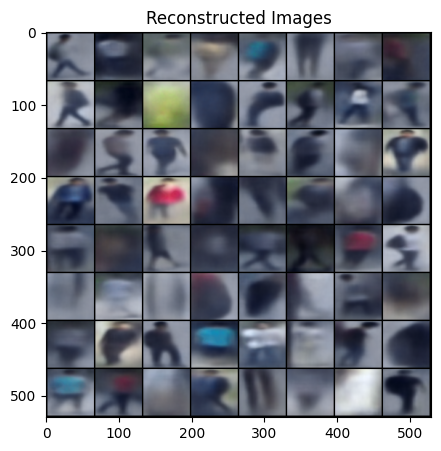

In [12]:
# Get a batch of images from your dataloader
dataiter = iter(train_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = encoder(images)[-1]  # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

### Loss on Train Set

In [13]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in train_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            # Forward pass through the encoder and then the decoder
            latent_representation = encoder(images)[-1]  # Assuming the last output is the latent representation
            reconstructed_imgs = decoder(latent_representation)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f'Average reconstruction loss on the train set: {average_loss}')


Average reconstruction loss on the train set: 0.26163185493399155


### Save Model Dict

In [14]:
# Save the decoder state dictionary
torch.save(decoder.state_dict(), 'decoder_t8_preds_detr101dc5_adamw_numblocks_1_ffdim_4096_heads_16_v2.pth')

### TODO: Declare Test Dataloader

In [ ]:
test_dataset = datasets.ImageFolder(root='./datasets/Avenue Dataset/objects/test/', transform=transform)

# Create the DataLoader to load the dataset.
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)

print(test_dataset)

### Visualize Reconstruction Loss on Test Batch

In [ ]:
# Get a batch of images from your dataloader
dataiter = iter(test_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = encoder(images)[-1]  # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

### Loss on Test Set

In [ ]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in test_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            # Forward pass through the encoder and then the decoder
            latent_representation = encoder(images)[-1]  # Assuming the last output is the latent representation
            reconstructed_imgs = decoder(latent_representation)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f'Average reconstruction loss on the test set: {average_loss}')

## UBNormal